In [11]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from dotenv import load_dotenv

sns.set_palette("Set2")
sns.set_style("whitegrid")
load_dotenv()

True

In this Lab, we will work with a smaller subset of the tracks that includes extracted features like: danceability, instrumentalness, tempo etc. The reason is, to interpret the results from the linear regression more easily (which is the main goal of the lab), since using all the 500+ features would be challenging in terms of explainability.
The goal of this Lab is to try to predict the popularity of a song (track_listens), based on the scores mentioned above.

# 1. Importing the data

In [12]:
tracks_all = pd.read_csv(os.getenv("TRACKS_PATH_PROCESSED"))
tracks_echonest = pd.read_csv(os.getenv("ECHONEST_PATH"), index_col=0, header=[0, 1, 2])

In [13]:
tracks_indexes = tracks_all.index.intersection(tracks_echonest.index)

In [14]:
target = tracks_all.loc[tracks_indexes]['track_listens']
genre = tracks_all.loc[tracks_indexes]['genre_top']
X = tracks_echonest.loc[tracks_indexes]['echonest', 'audio_features']
X = X.join(genre, how='inner')
continuous_features = [col for col in X.columns if col != 'genre_top']

In [15]:
X.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Pop
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Rock
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,Jazz
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Folk


# 2. EDA

In [16]:
target.describe()

count      7062.000000
mean       1905.894506
std        5961.620346
min          93.000000
25%         432.000000
50%         811.000000
75%        1750.500000
max      294602.000000
Name: track_listens, dtype: float64

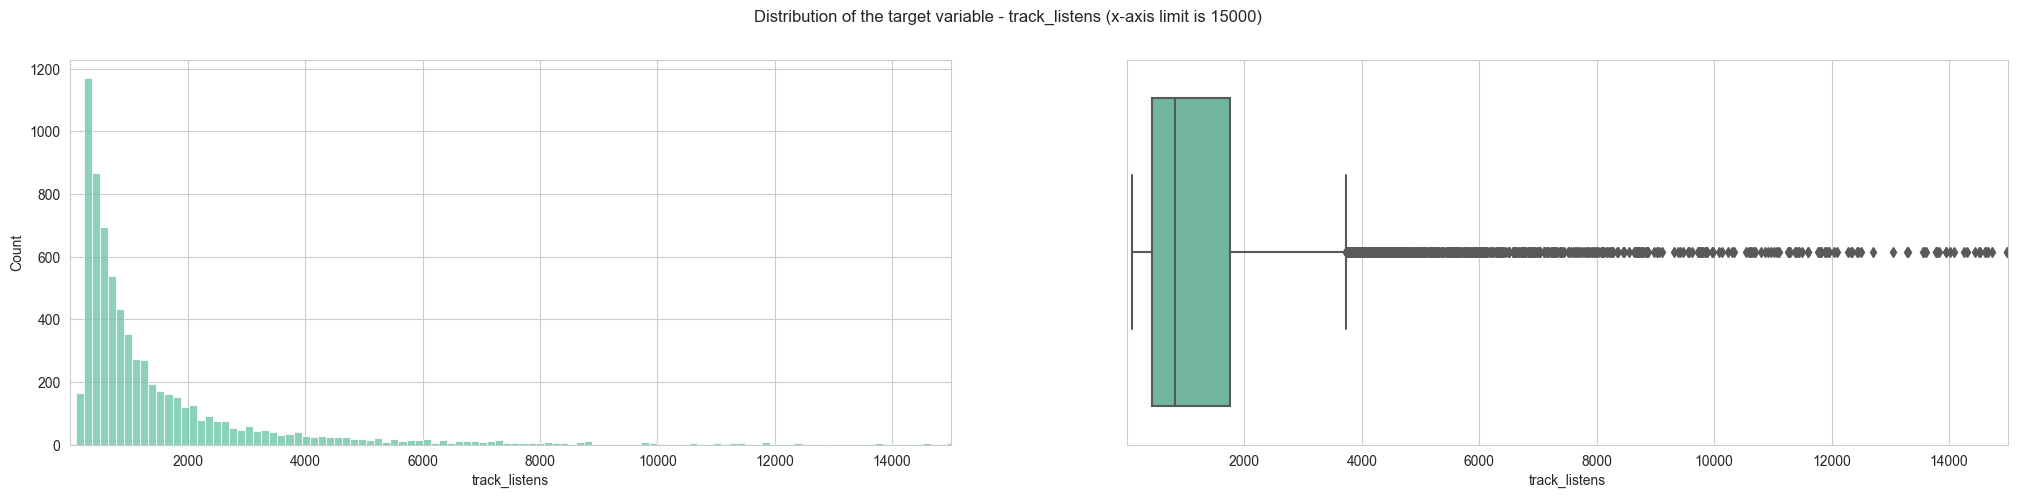

In [17]:
fig , axs = plt.subplots(1, 2, figsize=(25, 5))
axs[0].set_xlim(1, 15000)
sns.histplot(data=target, ax=axs[0])
axs[1].set_xlim(1, 15000)
sns.boxplot(x=target, ax=axs[1])
fig.suptitle('Distribution of the target variable - track_listens (x-axis limit is 15000)')
plt.show()

Due to the highly skewed distribution of track_listens, we will apply a log transformation to it. This will make analyzing the results more difficult, since we will be talking in terms of logarithms.

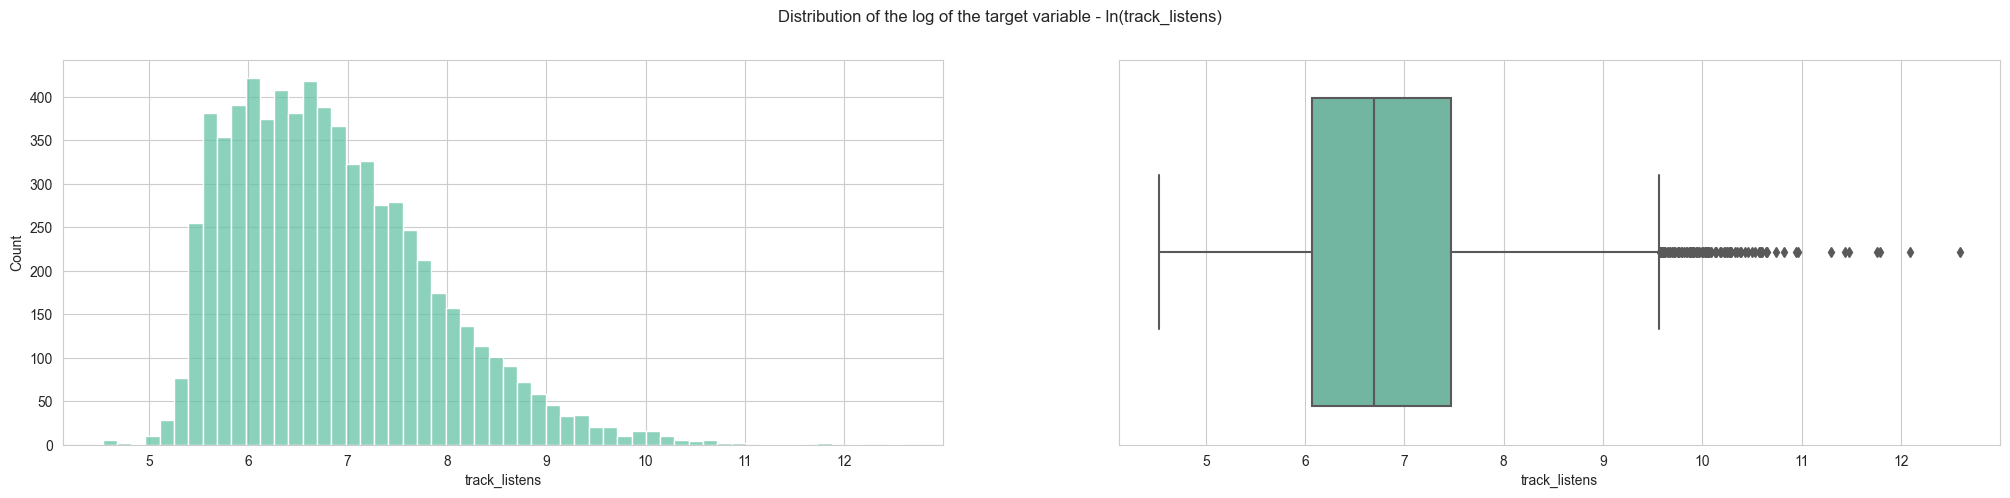

In [18]:
fig , axs = plt.subplots(1, 2, figsize=(25, 5))
sns.histplot(data=np.log(target), ax=axs[0])
sns.boxplot(x=np.log(target), ax=axs[1])
fig.suptitle('Distribution of the log of the target variable - ln(track_listens)')
plt.show()

In [19]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
acousticness,7062.0,0.598216,0.372698,9.035000e-07,0.219118,0.728618,0.955109,0.995796
danceability,7062.0,0.472767,0.191203,5.130749e-02,0.327312,0.464138,0.610395,0.966883
energy,7062.0,0.513610,0.284957,2.016590e-05,0.282832,0.521295,0.753905,0.999768
instrumentalness,7062.0,0.696855,0.327853,0.000000e+00,0.583165,0.862311,0.926588,0.997121
liveness,7062.0,0.191559,0.163281,2.529734e-02,0.102752,0.119454,0.213630,0.971968
speechiness,7062.0,0.106291,0.148028,2.232367e-02,0.037543,0.050000,0.090652,0.966177
tempo,7062.0,123.453047,35.944371,1.965900e+01,95.489000,120.526500,147.630250,251.072000
valence,7062.0,0.443649,0.281153,1.000000e-05,0.193962,0.422056,0.677177,0.999990


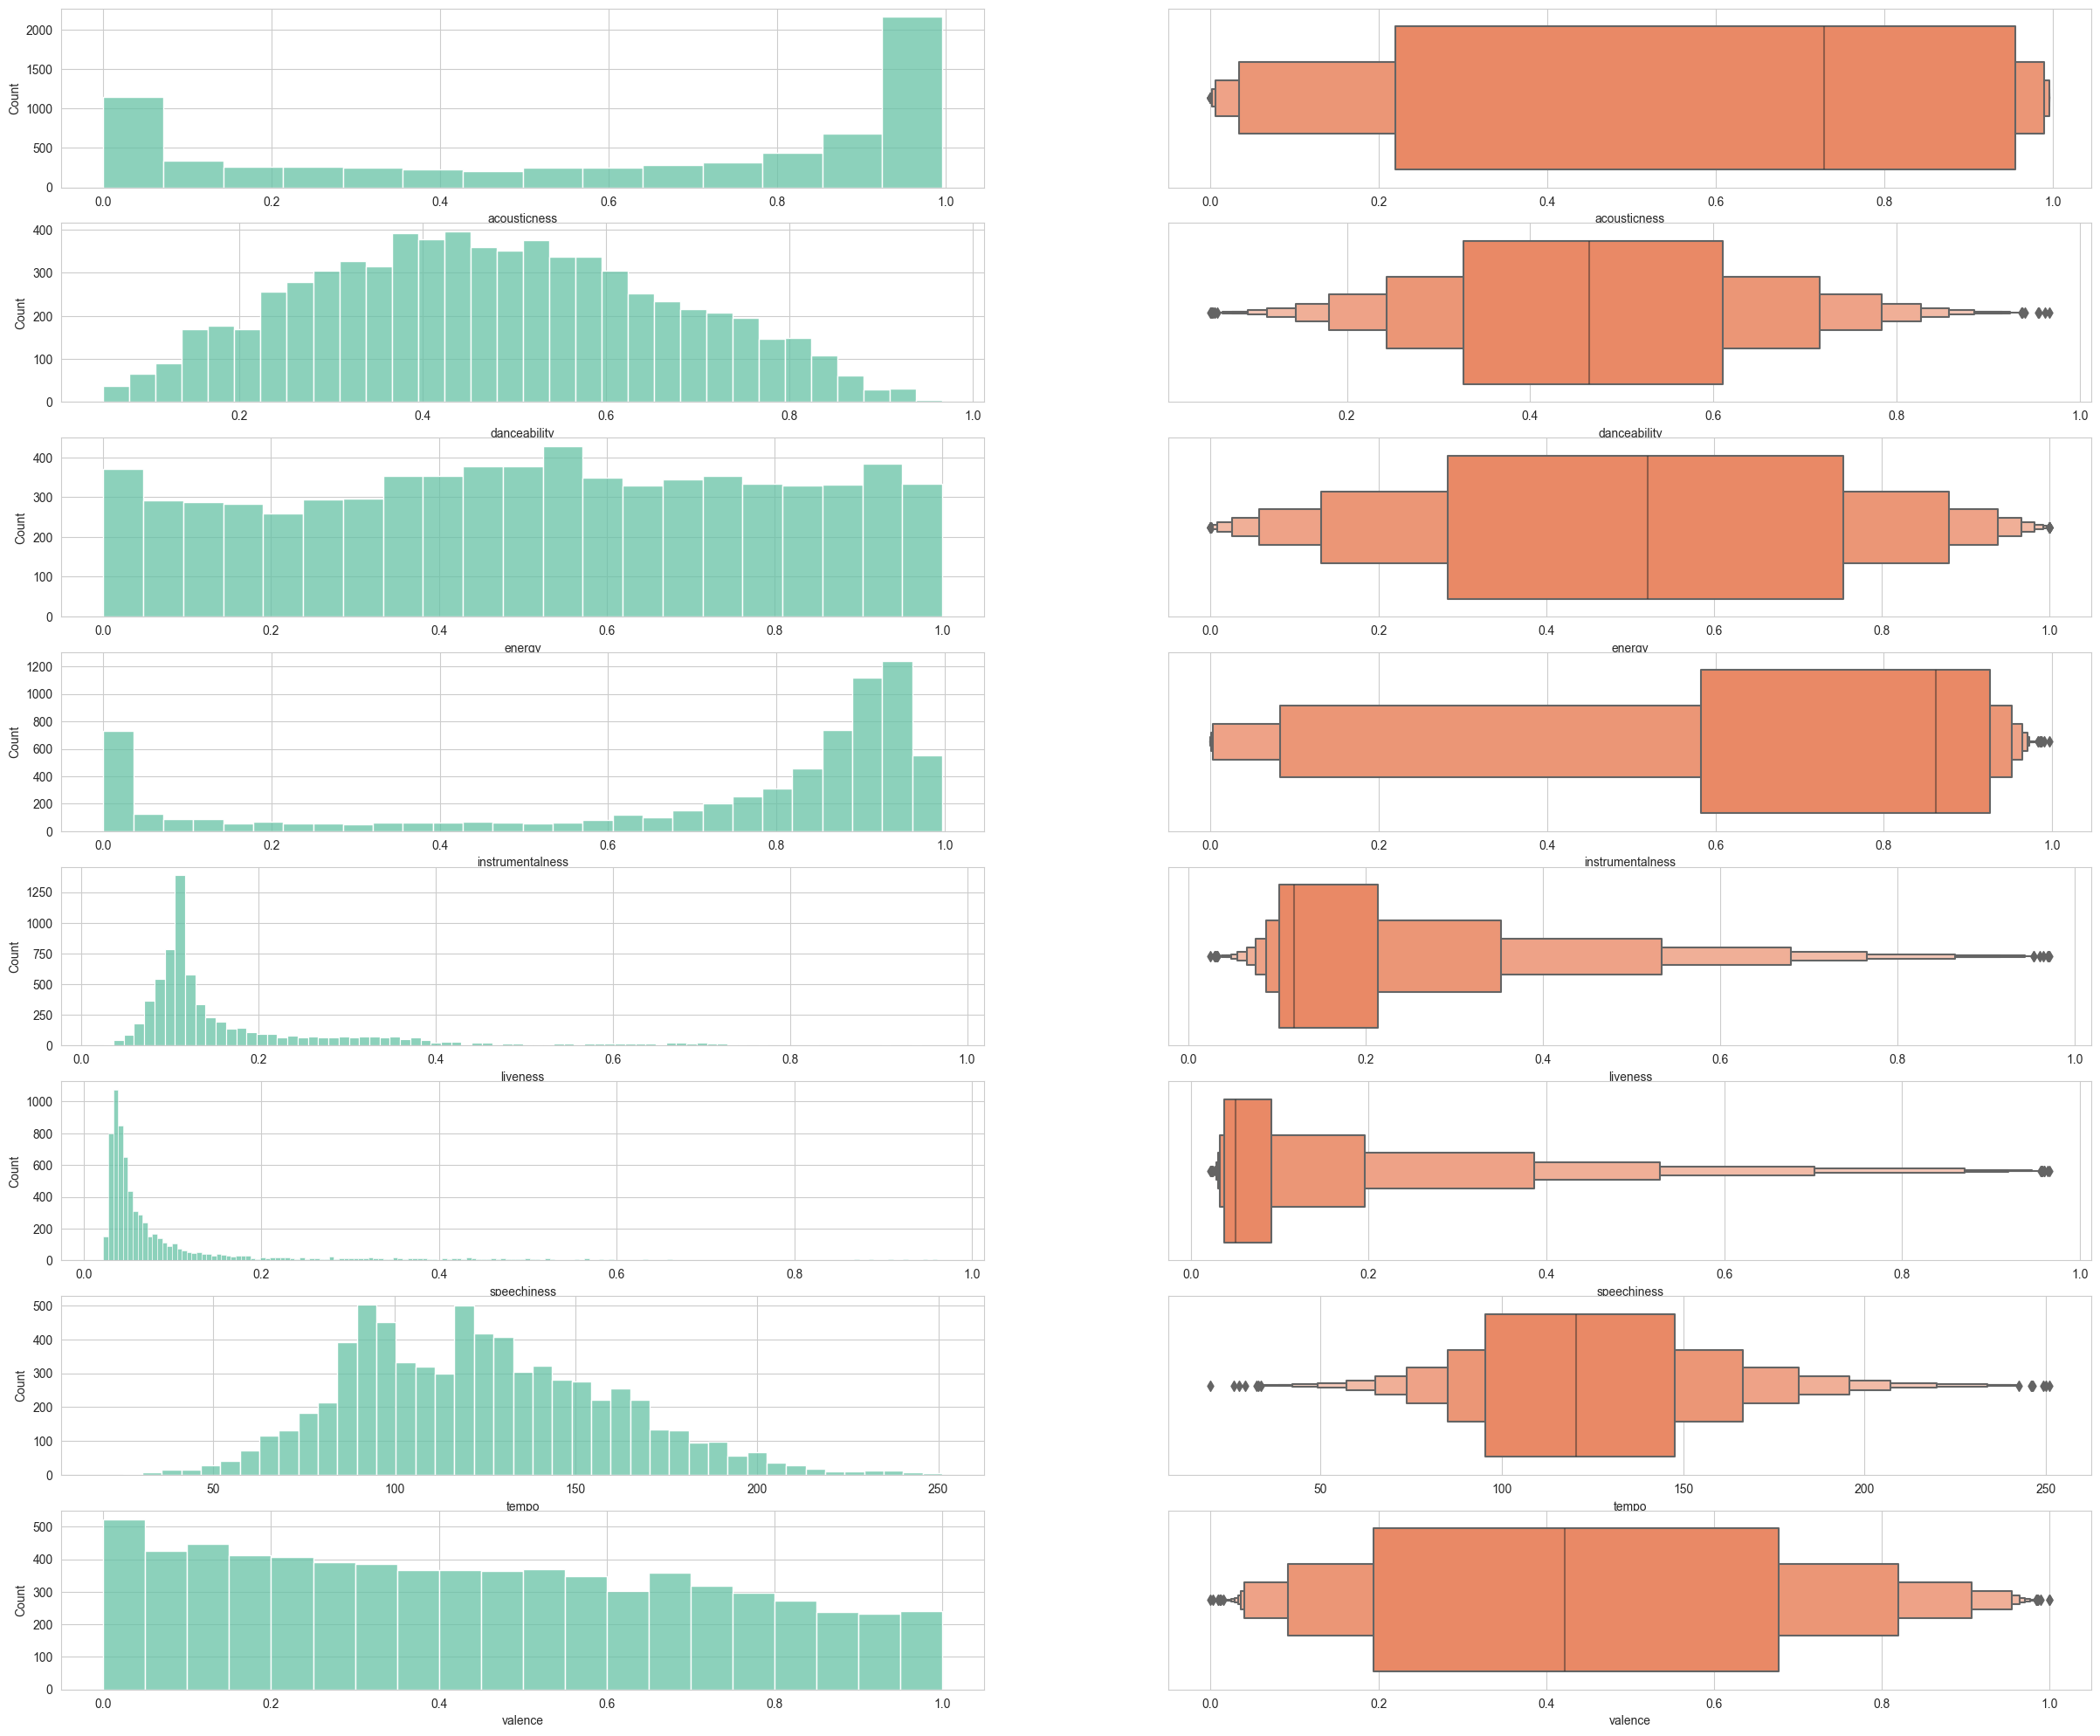

In [20]:
fig, axs = plt.subplots(8, 2, figsize=(30, 25))
subplots = list(range(8))

for k, col in enumerate(continuous_features):
    sns.histplot(data=X[col], ax=axs[subplots[k]][0])
    sns.boxenplot(x=X[col], ax=axs[subplots[k]][1], color='coral')
plt.show()

In [21]:
features_and_target = pd.concat([X[continuous_features], target], axis=1)

c:\Users\kblazhev\Desktop\deletable pr\Music-Genre-Classification-master\Music-Genre-Classification-master\.venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


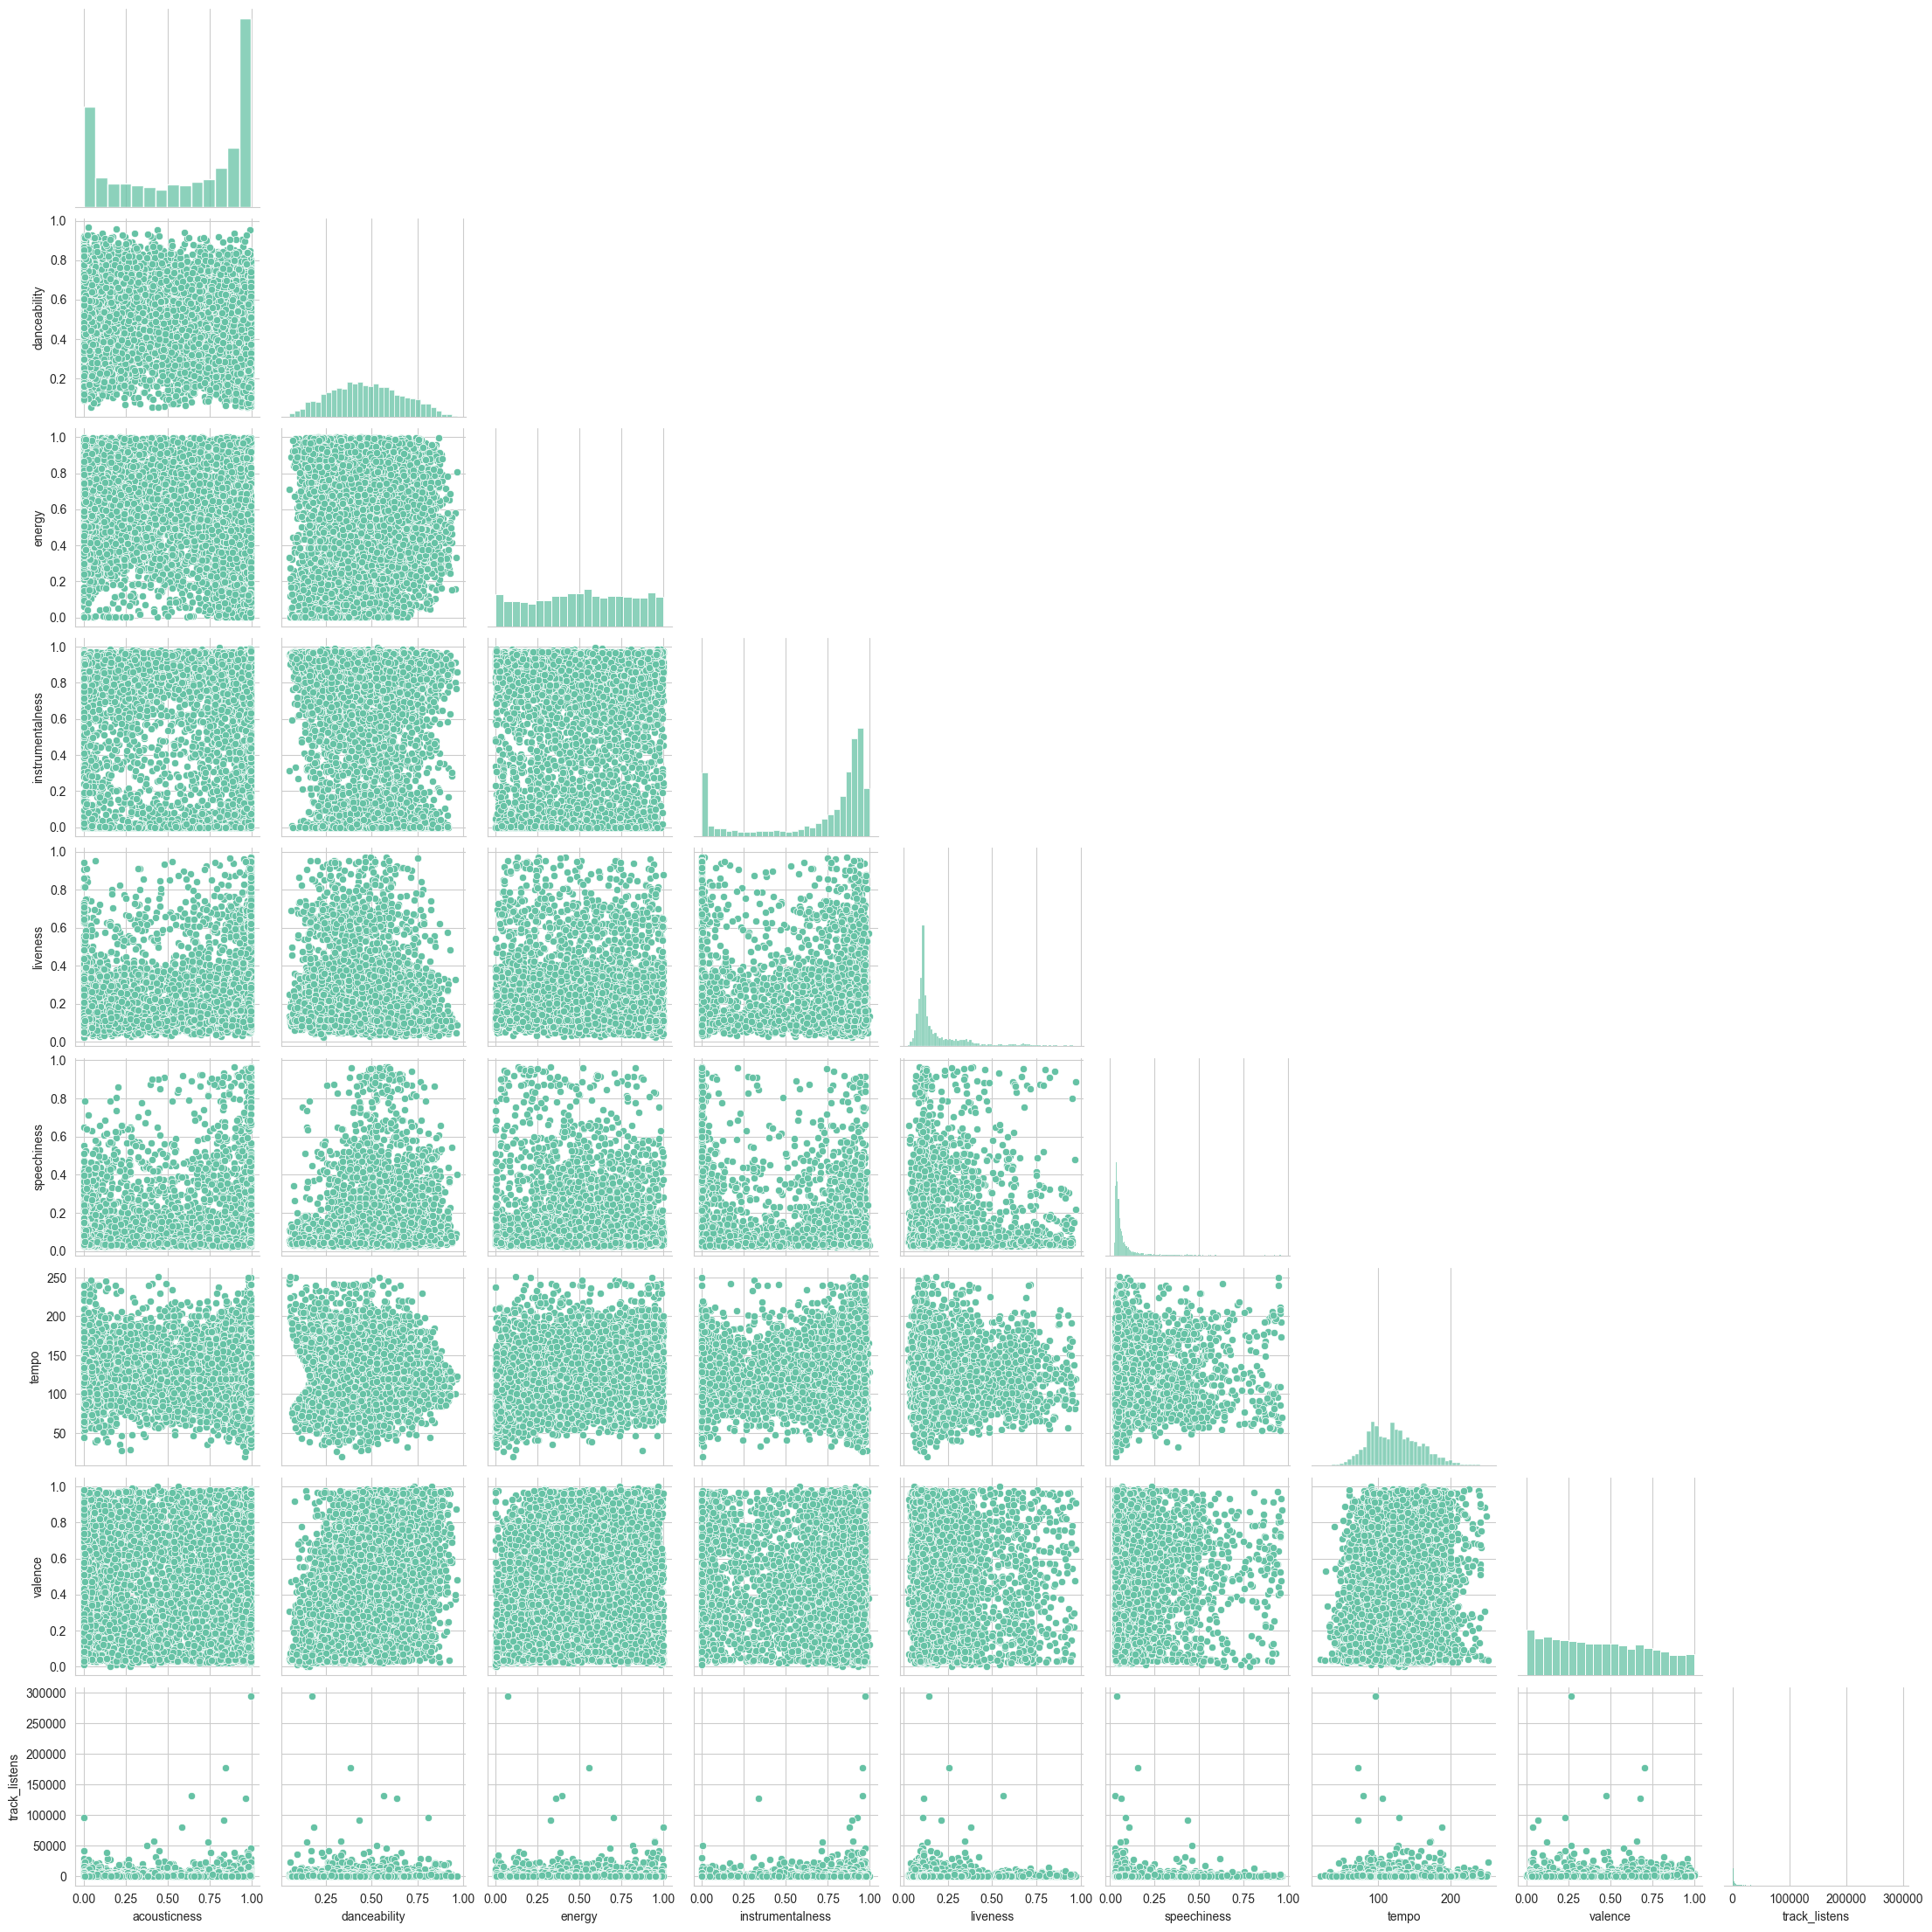

In [22]:
sns.pairplot(features_and_target, corner=True)

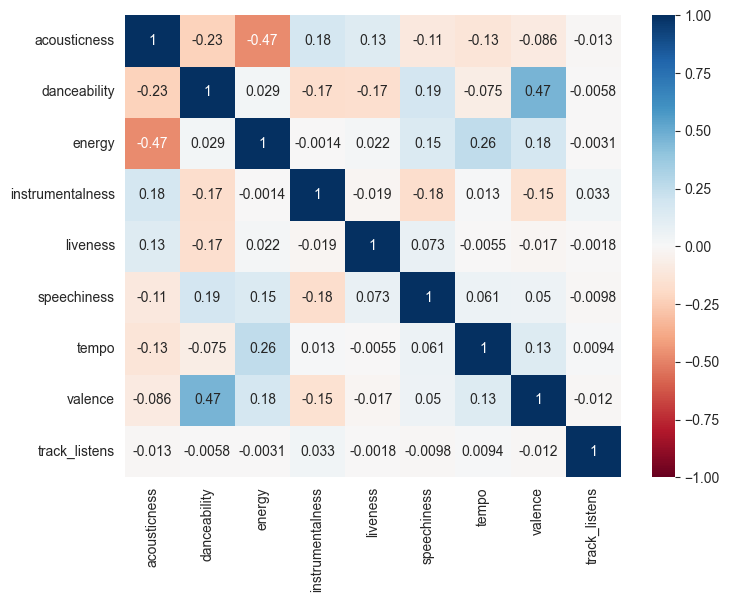

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(features_and_target.corr(method='spearman'), vmin=-1, vmax=1, annot=True, cmap='RdBu')
plt.show()

In [24]:
X['genre_top'].value_counts()

genre_top
Rock                   1945
Electronic             1743
Experimental            754
Hip-Hop                 636
Folk                    434
Instrumental            375
Pop                     281
Old-Time / Historic     247
Classical               198
International           167
Jazz                     97
Soul-RnB                 55
Spoken                   51
Country                  40
Blues                    36
Easy Listening            3
Name: count, dtype: int64

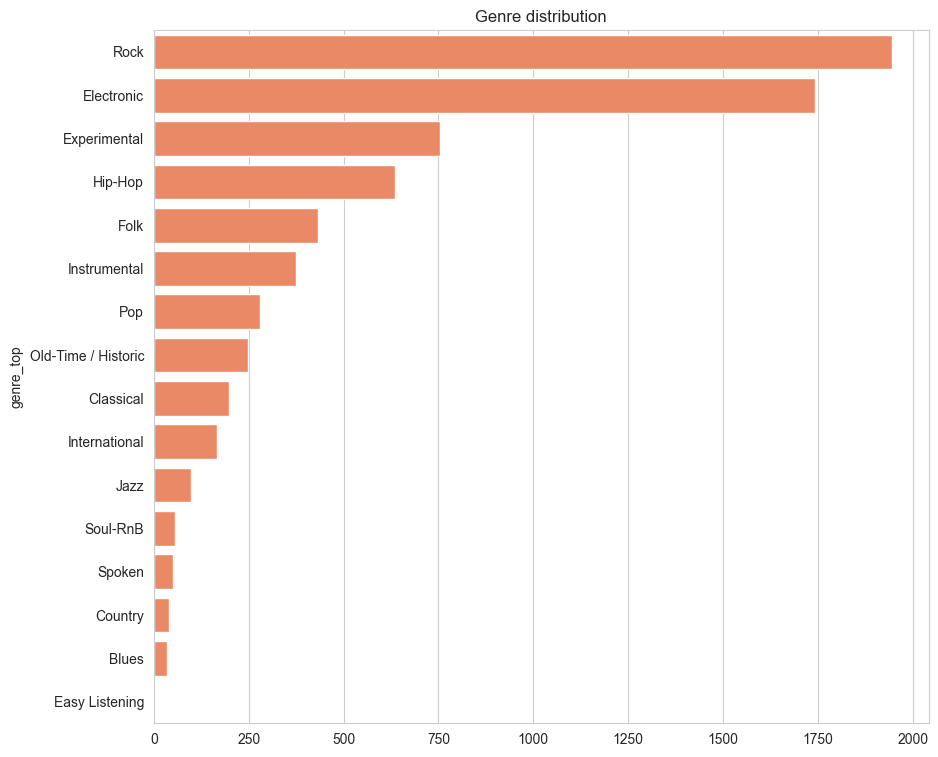

In [25]:
plt.figure(figsize=(10, 9))
plt.title('Genre distribution')
sns.barplot(y=X['genre_top'].value_counts().index, x=X['genre_top'].value_counts().values, color='coral')
plt.show()

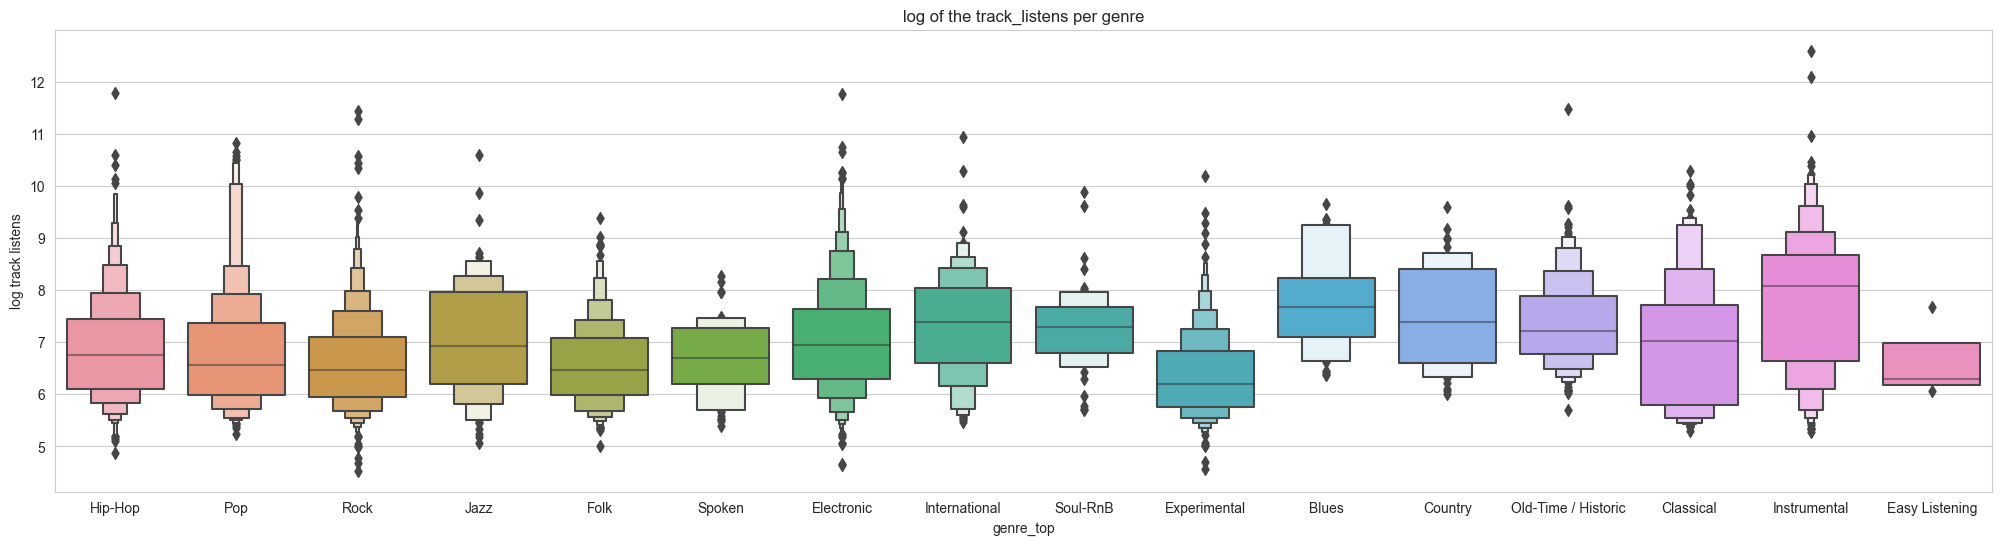

In [26]:
plt.figure(figsize=(25, 6))
plt.title('log of the track_listens per genre')
sns.boxenplot(data=pd.concat([X['genre_top'], np.log(target)], axis=1), x='genre_top', y='track_listens')
plt.ylabel('log track listens')
plt.show()

# 3. Feature Transforms

In [27]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

In [28]:
train_X, test_X, train_y, test_y = train_test_split(X, target, train_size=0.8, shuffle=True, random_state=123)

First we will transform the target variable, as noted above

In [29]:
transformer = FunctionTransformer(func=np.log, inverse_func=np.exp, validate=True, check_inverse=True)

train_y = pd.Series(transformer.fit_transform(train_y.to_numpy().reshape(-1, 1)).flatten(), index=train_y.index)
test_y = pd.Series(transformer.transform(test_y.to_numpy().reshape(-1, 1)).flatten(), index=test_y.index)

We one-hot encode the genre column (nominal attribute)

In [ ]:
encoder = OneHotEncoder(sparse=False, handle_unknown='error')

encoder.fit_transform(train_X[['genre_top']])
genre_oh_train = pd.DataFrame(encoder.transform(train_X[['genre_top']]), index=train_X.index, columns=encoder.get_feature_names_out(), dtype='int64')
genre_oh_test = pd.DataFrame(encoder.transform(test_X[['genre_top']]), index=test_X.index, columns=encoder.get_feature_names_out(), dtype='int64')

# 4. Training the models

In [31]:
report = pd.DataFrame()

## 4.1. Linear Regression

### 4.1.1 Model using audio features only

In [32]:
from sklearn.metrics import *
import statsmodels.api as sm


def print_results(test_y, pred_y, model_name):
    return pd.Series({'R2': r2_score(test_y, pred_y),
                      'MSE': mean_squared_error(test_y, pred_y),
                      'RMSE': mean_squared_error(test_y, pred_y, squared=False),
                      'MAE': mean_absolute_error(test_y, pred_y)}, name=model_name)

def plot_residuals(test_y, pred_y):
    residuals = test_y - pred_y
    fig, axs = plt.subplots(1, 2, figsize=(25, 5))
    fig.suptitle('Residuals')
    sns.histplot(x=residuals, ax=axs[0])
    axs[0].axvline(x=0, color='r')
    axs[0].axvline(x=np.mean(np.array(residuals)), color='y')
    sns.boxplot(x=residuals, ax=axs[1])

In [33]:
train_X_1 = train_X.drop('genre_top', axis=1, inplace=False)
test_X_1 = test_X.drop('genre_top', axis=1, inplace=False)

In [34]:
train_X_1 = sm.add_constant(train_X_1)
test_X_1 = sm.add_constant(test_X_1)

In [35]:
model_1 = sm.OLS(train_y, train_X_1).fit()

In [36]:
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.370
Date:                Sat, 16 Sep 2023   Prob (F-statistic):             0.0152
Time:                        11:11:12   Log-Likelihood:                -8094.9
No. Observations:                5649   AIC:                         1.621e+04
Df Residuals:                    5640   BIC:                         1.627e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.7937      0.085  

In [37]:
y_hat_1 = pd.Series(model_1.predict(test_X_1), index=test_X_1.index)
report = pd.concat([report, print_results(test_y, y_hat_1, 'audio_features')], axis=1)
print_results(test_y, y_hat_1, 'audio_features')

R2      0.000072
MSE     0.980302
RMSE    0.990102
MAE     0.794136
Name: audio_features, dtype: float64

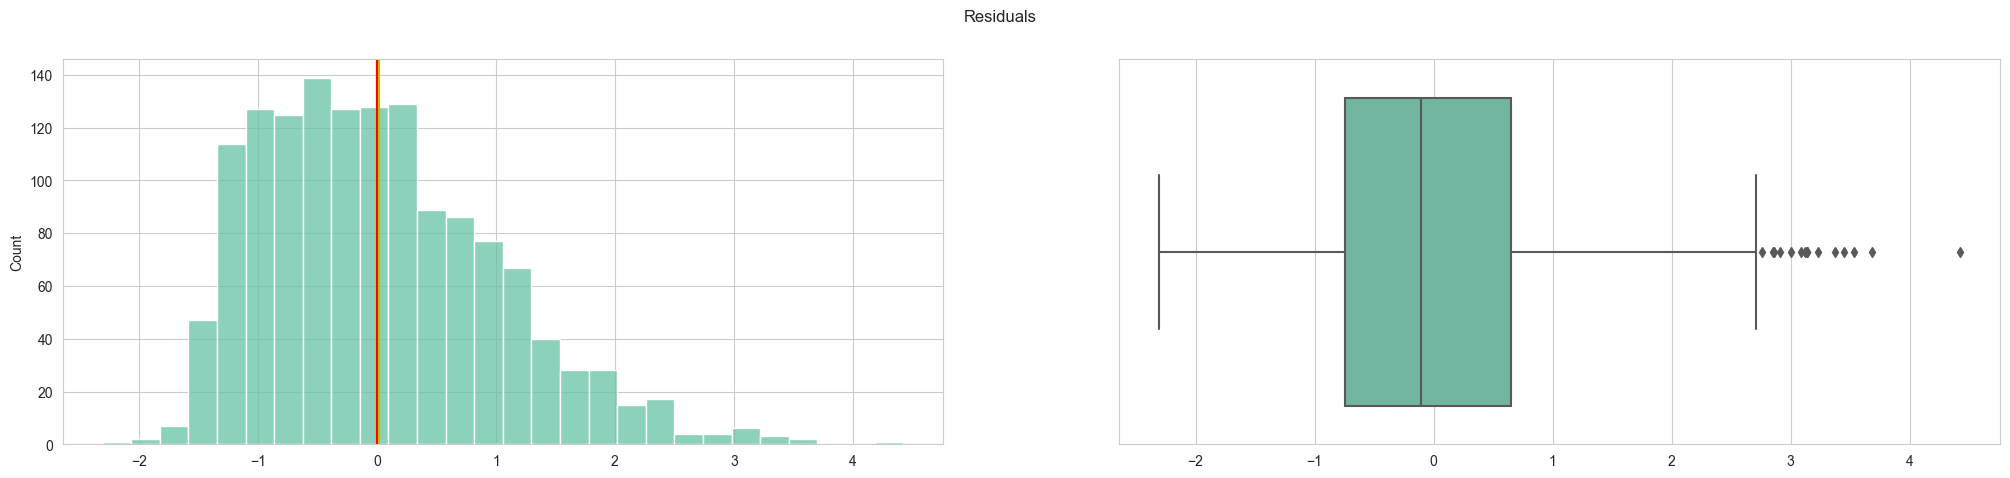

In [38]:
plot_residuals(test_y, y_hat_1)

Text(0.5, 1.0, 'Distribution of the predictions (y_hat)')

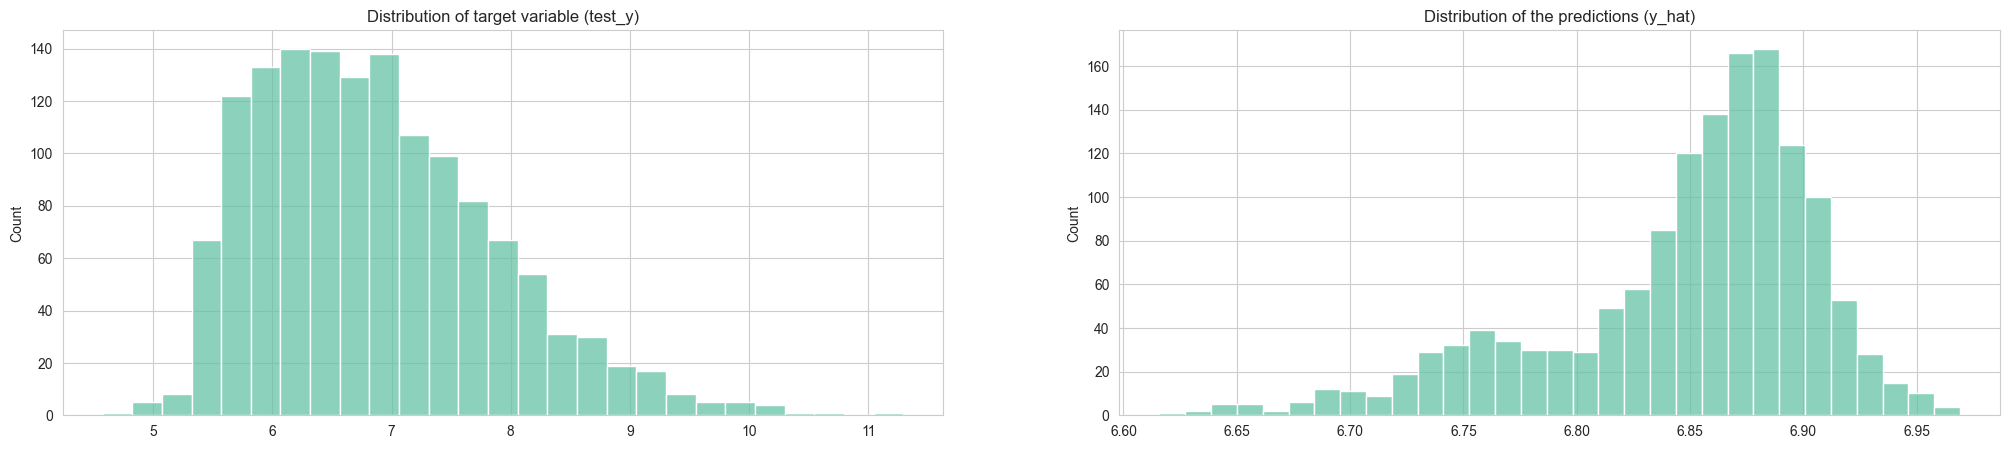

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5))
sns.histplot(x=test_y, ax=axs[0])
sns.histplot(x=y_hat_1, ax=axs[1])
axs[0].set_title('Distribution of target variable (test_y)')
axs[1].set_title('Distribution of the predictions (y_hat)')

### 4.1.2 Inspecting multicollinearity
Although there isn't a strong monotonic relationship between the attributes (as presented with the Spearman's rank correlation heatmap and the pairwise plots), we decided to drop the columns 'energy' and 'valence' and build a model without them.

In [45]:
train_X_2 = train_X_1.drop(['energy', 'valence'], axis=1, inplace=False)
test_X_2 = test_X_1.drop(['energy', 'valence'], axis=1, inplace=False)

In [46]:
model_2 = sm.OLS(train_y, train_X_2).fit()

In [47]:
y_hat_2 = pd.Series(model_2.predict(test_X_2), index=test_X_2.index)
report = pd.concat([report, print_results(test_y, y_hat_2, 'dropped_e&v')], axis=1)
print_results(test_y, y_hat_2, 'dropped_e&v')

R2      0.000611
MSE     0.979774
RMSE    0.989835
MAE     0.794548
Name: dropped_e&v, dtype: float64

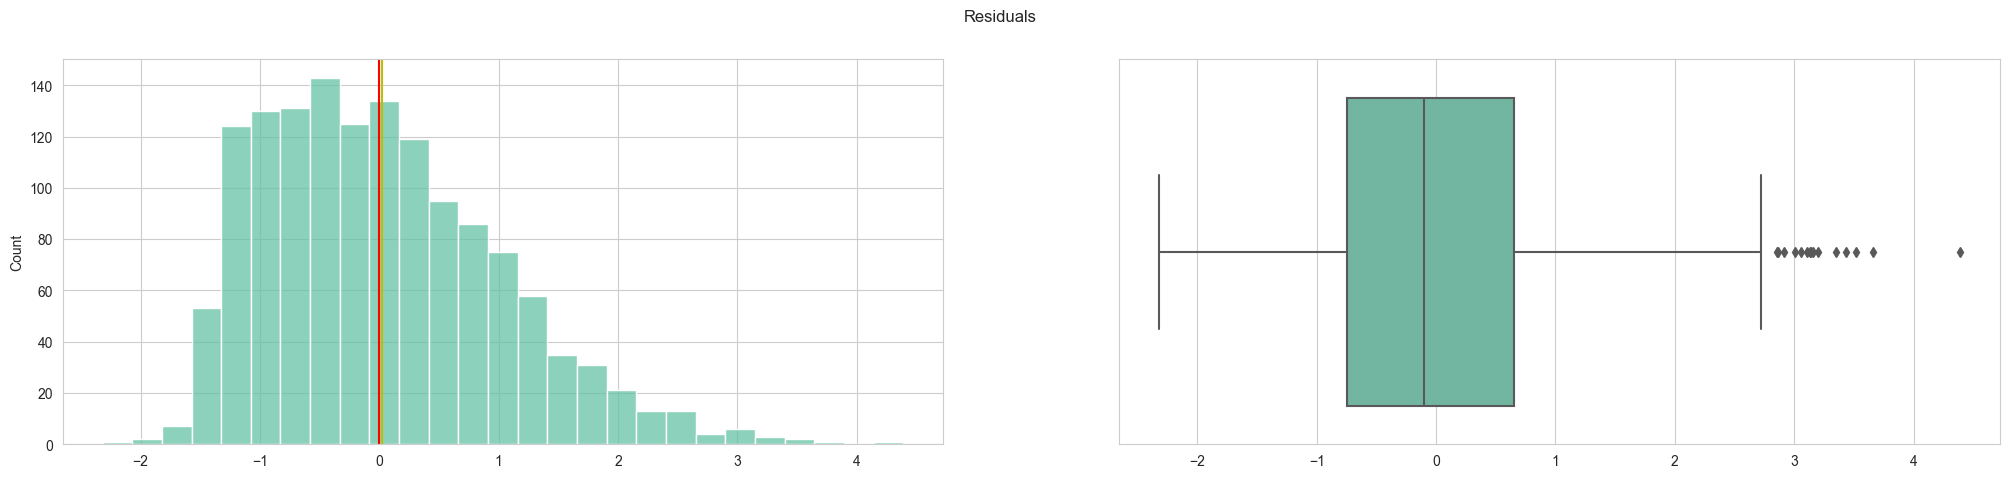

In [48]:
plot_residuals(test_y, y_hat_2)

Text(0.5, 1.0, 'Distribution of the predictions (y_hat)')

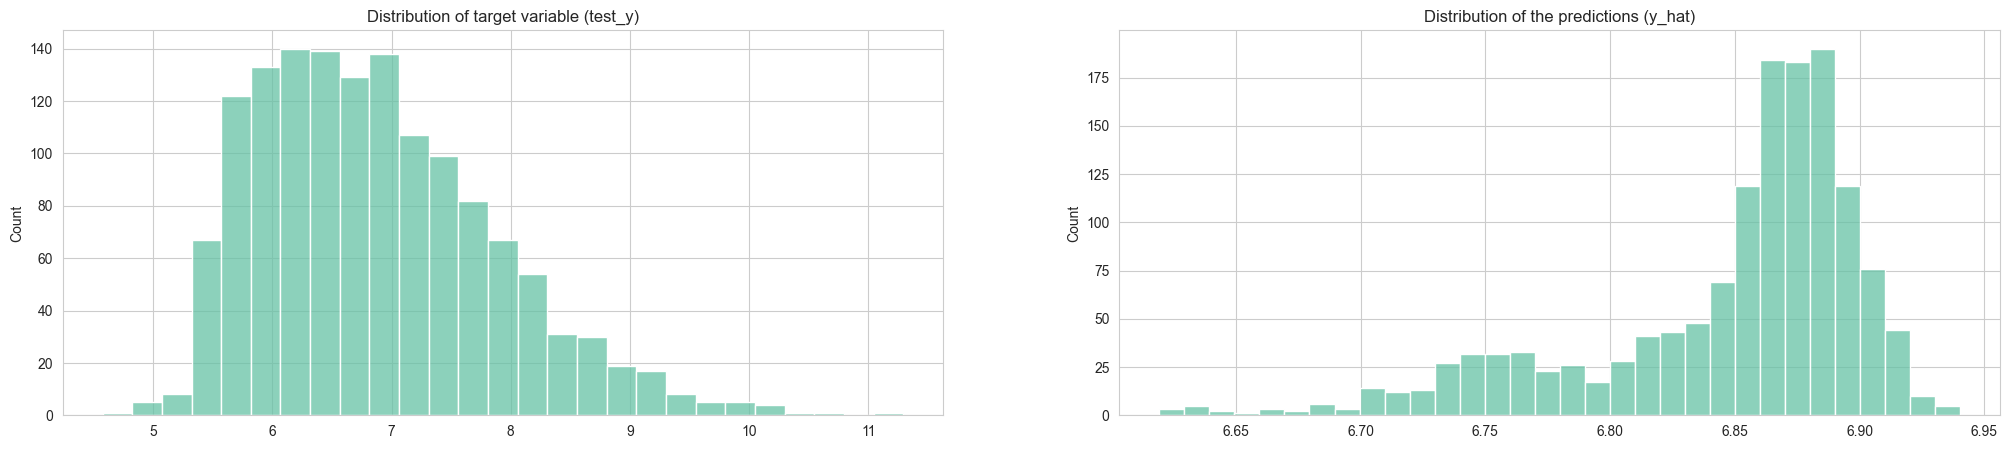

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5))
sns.histplot(x=test_y, ax=axs[0])
sns.histplot(x=y_hat_2, ax=axs[1])
axs[0].set_title('Distribution of target variable (test_y)')
axs[1].set_title('Distribution of the predictions (y_hat)')

### 4.1.3 Including Genre

Next we also include the one-hot encoded attribute that indicates the genre in which the track belongs to.

In [50]:
train_X_3 = pd.concat([train_X_1, genre_oh_train], axis=1)
test_X_3 = pd.concat([test_X_1, genre_oh_test], axis=1)

In [51]:
train_X_3 = sm.add_constant(train_X_3)
test_X_3 = sm.add_constant(test_X_3)

In [52]:
model_3 = sm.OLS(train_y, train_X_3).fit()

There is evidence to reject the null hypothesis that the coefficients are zero only for the instrumentalness feature from the audio features, and for most of the genre indicator features. Easy listening, Folk, Rock and Spoken seem to have no effect on the model, since there is strong evidence that their coefficients are 0 (we chose a significance level of 0.05).

In [54]:
print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     39.75
Date:                Sat, 16 Sep 2023   Prob (F-statistic):          1.74e-164
Time:                        11:16:10   Log-Likelihood:                -7679.0
No. Observations:                5649   AIC:                         1.541e+04
Df Residuals:                    5625   BIC:                         1.557e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [55]:
y_hat_3 = pd.Series(model_3.predict(test_X_3), index=test_X_3.index)
report = pd.concat([report, print_results(test_y, y_hat_3, 'with_genre')], axis=1)
print_results(test_y, y_hat_3, 'with_genre')

R2      0.099427
MSE     0.882897
RMSE    0.939626
MAE     0.744743
Name: with_genre, dtype: float64

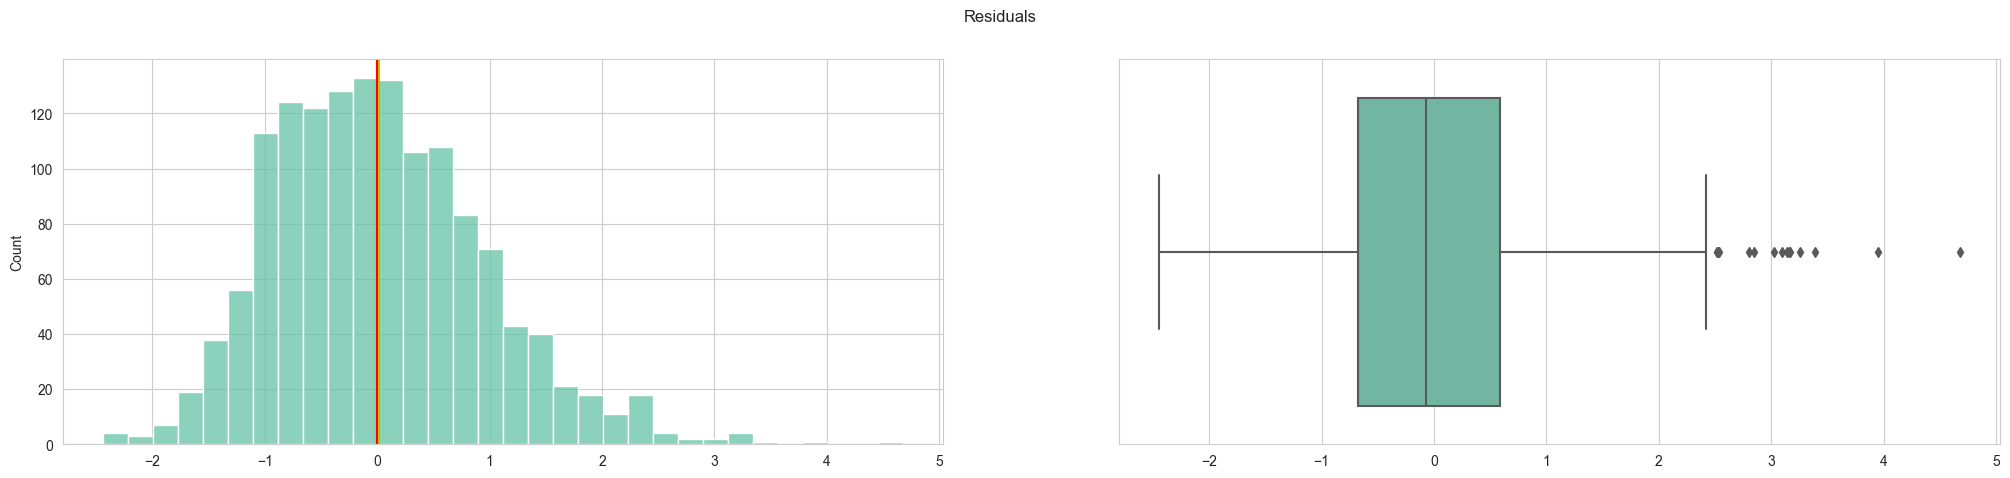

In [56]:
plot_residuals(test_y, y_hat_3)

Text(0.5, 1.0, 'Distribution of the predictions (y_hat)')

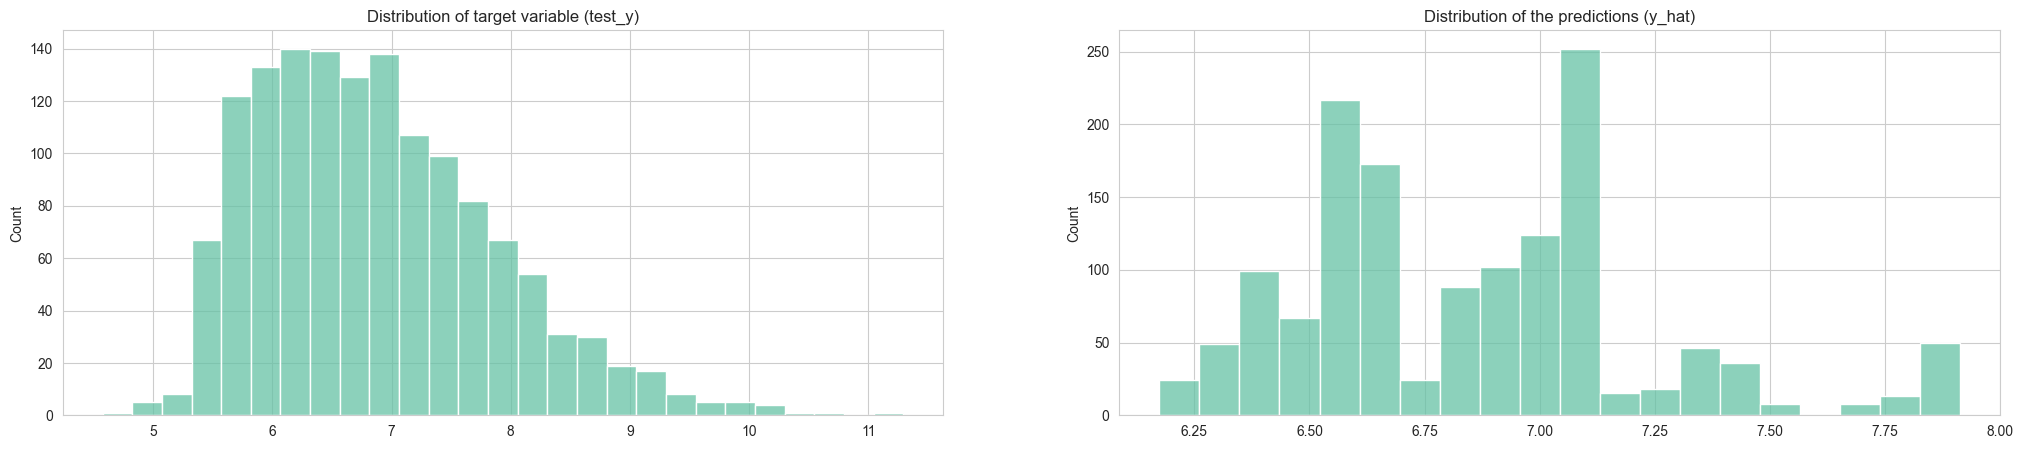

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5))
sns.histplot(x=test_y, ax=axs[0])
sns.histplot(x=y_hat_3, ax=axs[1])
axs[0].set_title('Distribution of target variable (test_y)')
axs[1].set_title('Distribution of the predictions (y_hat)')

We can conclude that the available features at hand are bad predictors for the popularity score. The $R^2$ score is 0.0994, meaning that approximately 9.9% of the variance in the target variable can be explained by the independent variables in the model.
 The model has limited explanatory power, which is not surprising since none of the predictors are correlated to the target.
The model is clearly underfitting, so we can try to fit a more complex model, where we define a new feature vector, using polynomial basis functions. By explicitly modeling interactions between the input attributes, it is possible that the model learns new patterns.

## 4.2 Polynomial basis functions with L1 regularization

We will derive polynomial features for the continuous attributes only, because otherwise the data would be sparse and features like "$genreBlues^2$" would be uninformative.

In [58]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-4, -0.5, 30)

def find_best_params(model, train_X, train_y, param_grid, cv):
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=cv,
        n_jobs=-1,
        verbose=3
    )
    grid_search.fit(train_X, train_y)

    print('Best alpha: ', grid_search.best_params_)
    return grid_search.best_estimator_

In [59]:
audio_features = [col for col in train_X_3 if train_X_3[col].dtype == 'float64' and col != 'const']

In [60]:
poly = PolynomialFeatures(degree=2, include_bias=True)

train_X_4 = pd.DataFrame(poly.fit_transform(train_X_3[audio_features]), index=train_X_3.index, columns=poly.get_feature_names_out())
train_X_4 = pd.concat([train_X_4, genre_oh_train], axis=1)

test_X_4 = pd.DataFrame(poly.transform(test_X_3[audio_features]), index=test_X_3.index, columns=poly.get_feature_names_out())
test_X_4 = pd.concat([test_X_4, genre_oh_test], axis=1)

In [61]:
train_X_4.head(3)

,1,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,acousticness^2,...,genre_top_Folk,genre_top_Hip-Hop,genre_top_Instrumental,genre_top_International,genre_top_Jazz,genre_top_Old-Time / Historic,genre_top_Pop,genre_top_Rock,genre_top_Soul-RnB,genre_top_Spoken
7872,1.0,0.894827,0.563550,0.520524,0.137180,0.061635,0.057370,137.410,0.849912,0.800715,...,0,0,0,0,0,0,0,1,0,0
25150,1.0,0.995584,0.075781,0.169593,0.972870,0.175296,0.034879,66.978,0.248138,0.991187,...,0,0,0,1,0,0,0,0,0,0
6376,1.0,0.989142,0.663523,0.716656,0.930688,0.620431,0.204059,122.433,0.974694,0.978403,...,0,0,0,0,0,0,0,0,0,0


In [62]:
lasso = Lasso()
lasso_fit = find_best_params(lasso, pd.concat([train_X_4, test_X_4], axis=0), pd.concat([train_y, test_y], axis=0), dict(alpha=alphas), cv=5)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best alpha:  {'alpha': 0.0004012807031942776}


In [63]:
print('   Intercept: ', lasso_fit.intercept_)
print('Coefficients: ', lasso_fit.coef_)

   Intercept:  7.125867808618311
Coefficients:  [ 0.00000000e+00 -2.90352353e-01 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -3.29716165e-04
 -2.08378519e-01  1.89742869e-01 -6.29114997e-02 -9.61131734e-02
  5.77022968e-02  0.00000000e+00 -0.00000000e+00  2.56595738e-04
  1.47572590e-01 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  1.26540792e-04 -0.00000000e+00
  1.11070337e-01 -0.00000000e+00  1.49215305e-01 -0.00000000e+00
 -1.09957678e-03  1.33388646e-01 -7.22301017e-02  1.75100973e-02
  2.81143197e-01  9.28781395e-04 -0.00000000e+00  8.06714631e-02
 -5.94173911e-01 -3.17155089e-04 -2.23188250e-02  0.00000000e+00
 -3.62217164e-05 -2.07833677e-01 -7.59865540e-07  9.54766269e-04
  0.00000000e+00  6.73552619e-01 -4.59640322e-02  3.63286442e-01
 -0.00000000e+00  0.00000000e+00 -6.99045492e-01 -4.83256477e-01
 -1.78512256e-01  7.31884736e-01  2.90677871e-01  9.37493916e-03
  3.40579495e-01 -2.24000666e-01 -4.500235

In [64]:
y_hat_4 = lasso_fit.predict(test_X_4)
report = pd.concat([report, print_results(test_y, y_hat_4, 'lasso_poly')], axis=1)
print_results(test_y, y_hat_4, 'lasso_poly')

R2      0.109021
MSE     0.873491
RMSE    0.934608
MAE     0.741250
Name: lasso_poly, dtype: float64

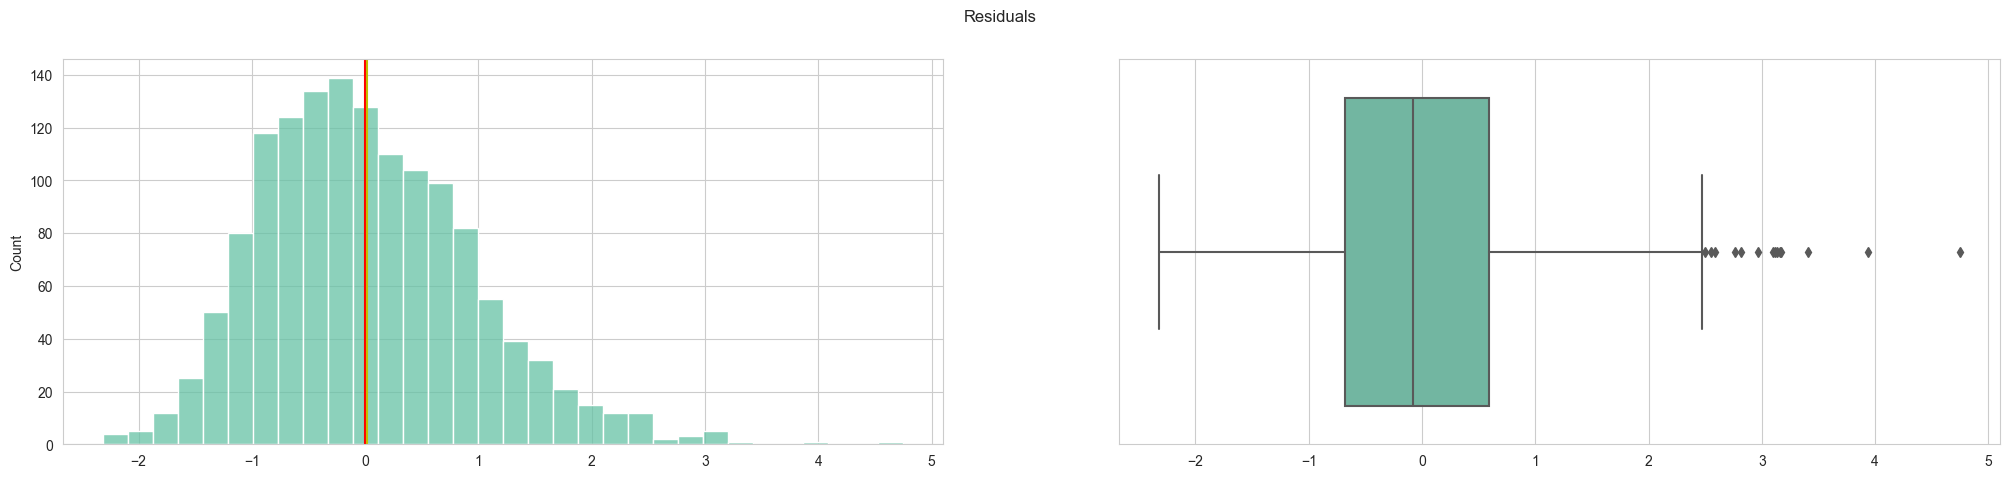

In [65]:
plot_residuals(test_y, y_hat_4)

Text(0.5, 1.0, 'Distribution of the predictions (y_hat)')

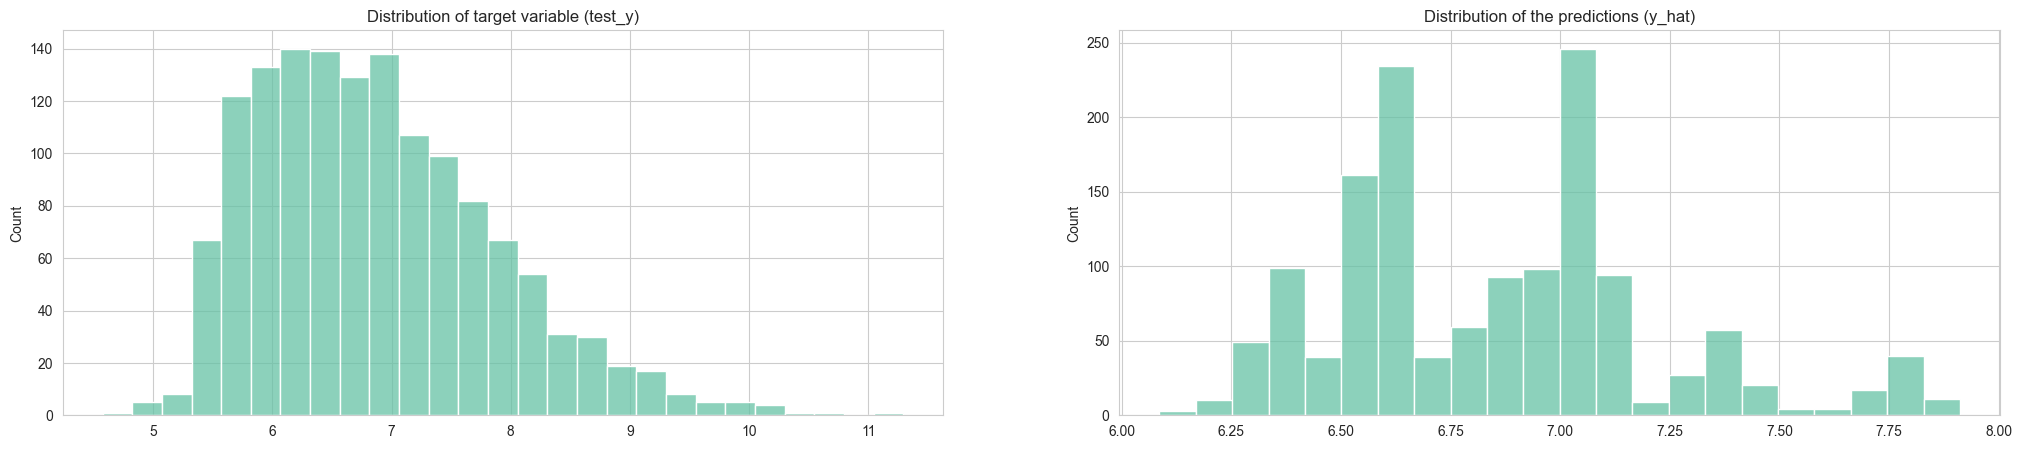

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5))
sns.histplot(x=test_y, ax=axs[0])
sns.histplot(x=y_hat_4, ax=axs[1])
axs[0].set_title('Distribution of target variable (test_y)')
axs[1].set_title('Distribution of the predictions (y_hat)')

## 4.3 Polynomial basis functions with L2 regularization

In [67]:
ridge = Ridge()
ridge_fit = find_best_params(ridge, pd.concat([train_X_4, test_X_4], axis=0), pd.concat([train_y, test_y], axis=0), dict(alpha=alphas), cv=5)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best alpha:  {'alpha': 0.31622776601683794}


In [68]:
print('   Intercept: ', ridge_fit.intercept_)
print('Coefficients: ', ridge_fit.coef_)

   Intercept:  7.482366763351411
Coefficients:  [ 0.00000000e+00 -6.63259257e-01 -3.27364782e-01 -4.33318660e-01
  5.02499711e-02 -5.10796570e-01 -1.59762360e-01 -4.33816008e-04
 -2.08443915e-01  3.14960981e-01 -7.08751166e-02 -5.90585325e-02
  1.50370045e-01  3.01038859e-01  1.39284921e-03  5.76057094e-04
  3.03267894e-01  7.69419623e-02  1.95484424e-01  1.02669805e-01
  3.27224686e-01  4.09492374e-01  1.95168688e-04 -5.52365387e-02
  2.24756080e-01  7.64153078e-02  5.73915456e-01 -1.14568685e-01
 -7.74320623e-04  2.36359768e-01 -2.19347060e-01  1.22735197e-02
  4.12168066e-01  8.95243224e-04 -1.31896176e-01  3.35814695e-01
 -1.04127839e+00 -6.30267384e-04 -3.49546721e-01  1.77552241e-01
  4.36740538e-04 -4.91520564e-01 -2.22780585e-06  1.18558625e-03
  3.93591318e-02  7.51160675e-01 -6.40252607e-02  4.33868080e-01
 -3.08781933e-01 -8.15785457e-03 -7.16005769e-01 -4.98023282e-01
 -1.92670778e-01  7.26680395e-01  2.93758744e-01  3.17386735e-02
  3.42188356e-01 -2.45770127e-01 -4.611660

In [69]:
y_hat_5 = ridge_fit.predict(test_X_4)
report = pd.concat([report, print_results(test_y, y_hat_5, 'ridge_poly')], axis=1)
print_results(test_y, y_hat_5, 'ridge_poly')

R2      0.114608
MSE     0.868014
RMSE    0.931673
MAE     0.736858
Name: ridge_poly, dtype: float64

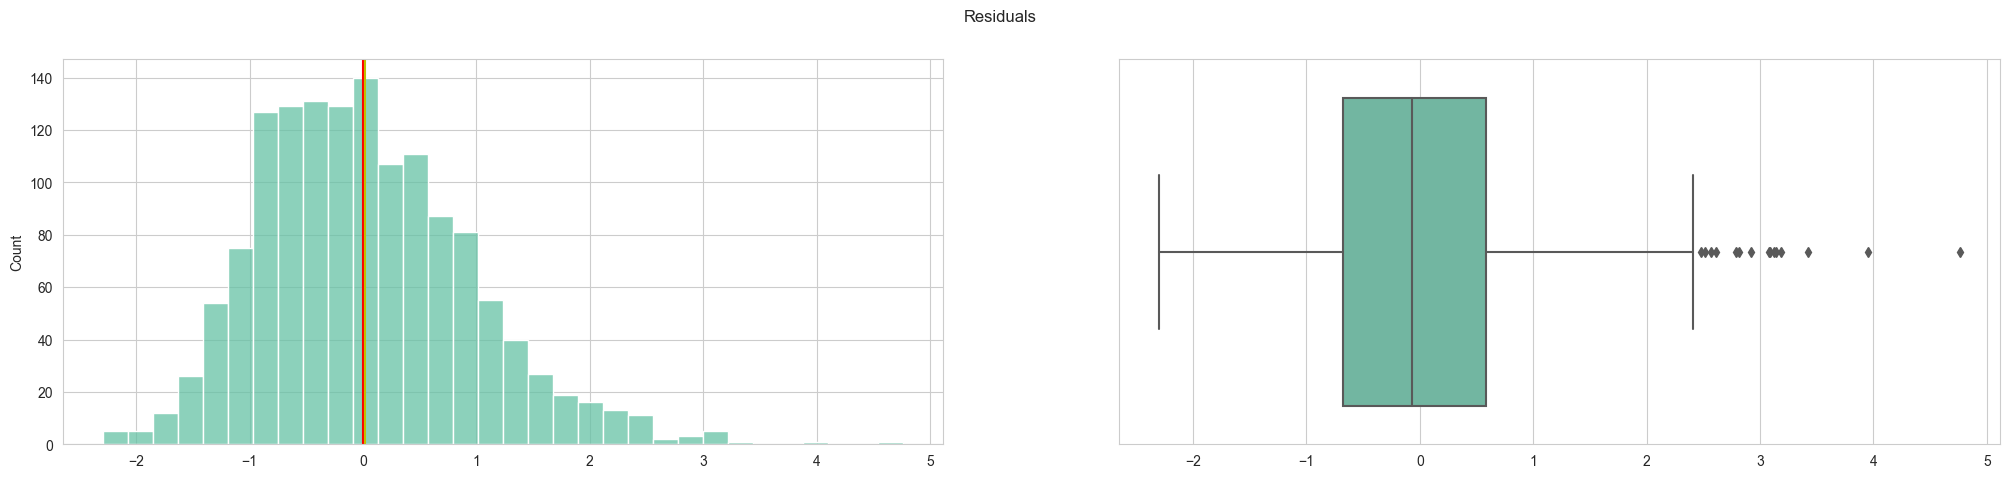

In [72]:
plot_residuals(test_y, y_hat_5)

Text(0.5, 1.0, 'Distribution of the predictions (y_hat)')

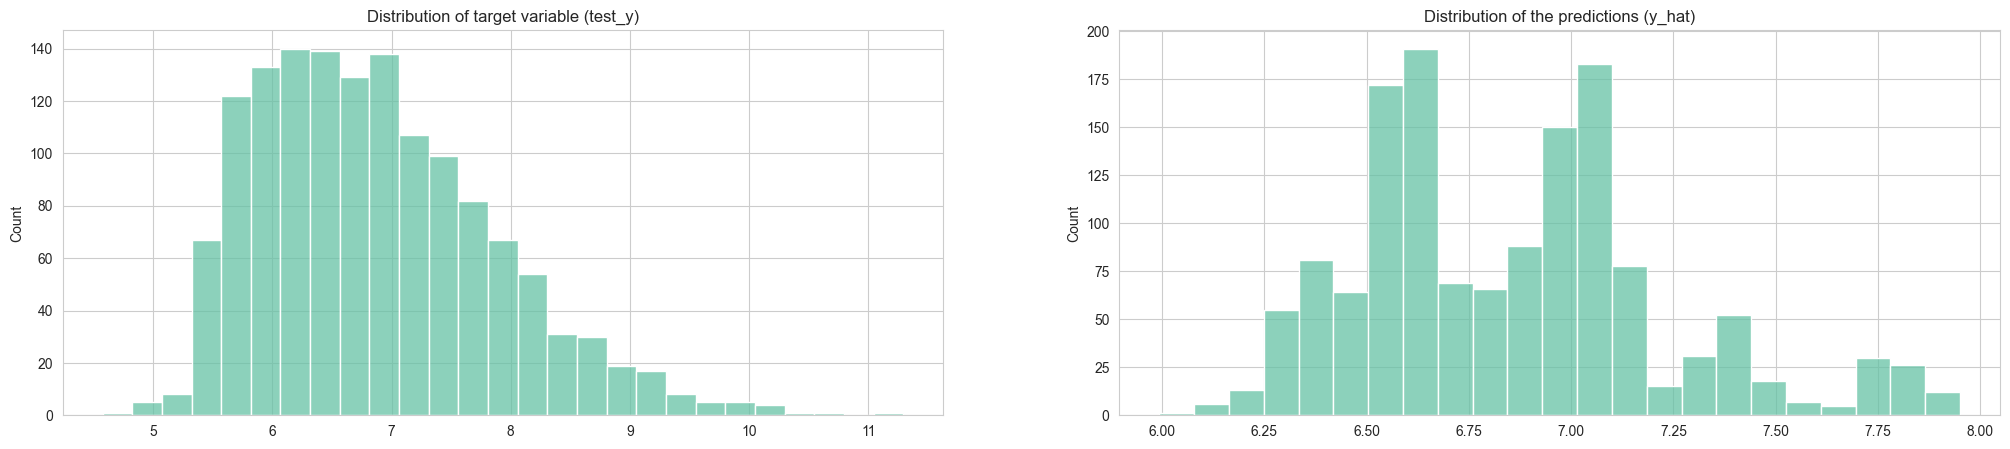

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5))
sns.histplot(x=test_y, ax=axs[0])
sns.histplot(x=y_hat_5, ax=axs[1])
axs[0].set_title('Distribution of target variable (test_y)')
axs[1].set_title('Distribution of the predictions (y_hat)')

# 5. Results

In [74]:
report

,audio_features,dropped_e&v,with_genre,lasso_poly,ridge_poly
R2,0.000072,0.000611,0.099427,0.109021,0.114608
MSE,0.980302,0.979774,0.882897,0.873491,0.868014
RMSE,0.990102,0.989835,0.939626,0.934608,0.931673
MAE,0.794136,0.794548,0.744743,0.741250,0.736858


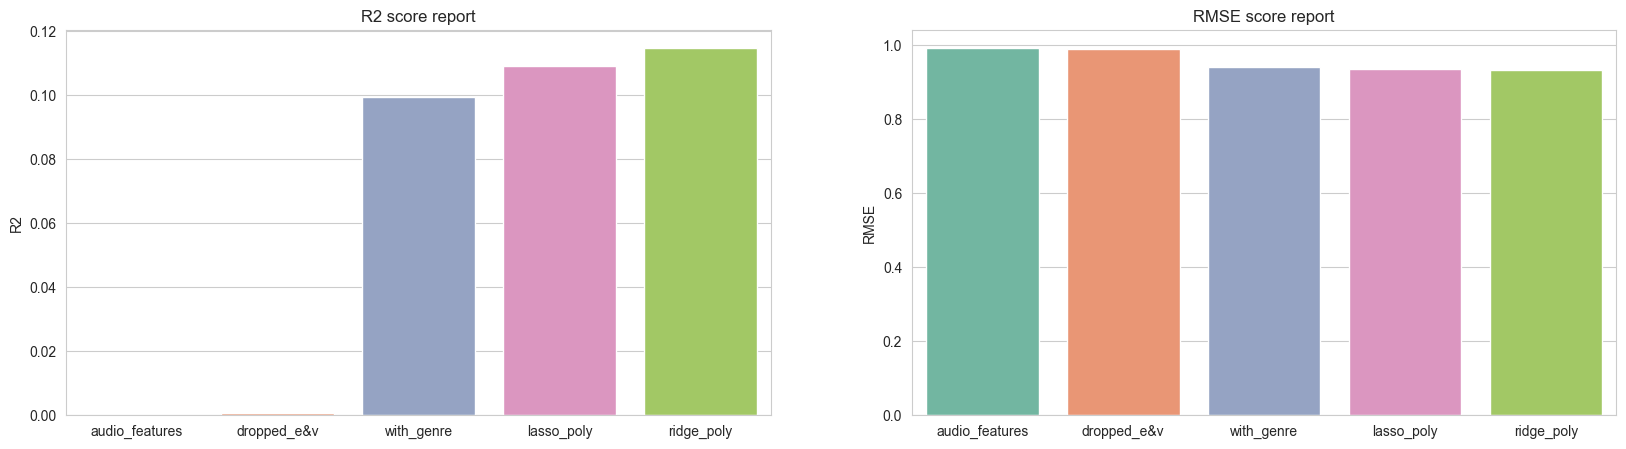

In [75]:
_, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.barplot(x=report.T['R2'].index, y=report.T['R2'], ax=axs[0])
axs[0].set_title('R2 score report')
sns.barplot(x=report.T['RMSE'].index, y=report.T['RMSE'], ax=axs[1])
axs[1].set_title('RMSE score report')
plt.show()

Although we managed to make slight improvements in the metrics, the effect of using polynomial basis function expansions along with regularization methods did not improve the models by much. This is likely due to our attributes not being good predictors for the target variable.